In [43]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
from statistics import mean, stdev
from math import sqrt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

Анализ розничной торговли с помощью проекта Walmart

В этом проекте мы проведем RFM-анализ по клиентам Walmart, анализ продукции магазинов и анализ географии продаж.

<h4>Загружаем данные

In [44]:
df = pd.read_csv('Walmart.csv', sep=',')

In [45]:
df

,Order ID,Order Date,Ship Date,Customer Name,Country,City,State,Category,Product Name,Sales,Quantity,Profit
0,CA-2013-138688,13-06-2013,17-06-2013,Darrin Van Huff,United States,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87
1,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17
2,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97
3,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72
4,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78
...,...,...,...,...,...,...,...,...,...,...,...,...
3198,CA-2013-125794,30-09-2013,04-10-2013,Maris LaWare,United States,Los Angeles,California,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.24,1.0,15.22
3199,CA-2014-121258,27-02-2014,04-03-2014,Dave Brooks,United States,Costa Mesa,California,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.96,2.0,15.63
3200,CA-2014-121258,27-02-2014,04-03-2014,Dave Brooks,United States,Costa Mesa,California,Phones,Aastra 57i VoIP phone,258.58,2.0,19.39
3201,CA-2014-121258,27-02-2014,04-03-2014,Dave Brooks,United States,Costa Mesa,California,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.60,4.0,13.32


<h4>Для удобства переименовываем колонки

In [8]:
df.rename(columns={'Order ID': 'order_id', 'Order Date': 'Order_date','Ship Date':'Ship_date', 'Customer Name':'Customer_name', 'Product Name':'Product_name'}, inplace=True)

In [9]:
df.head()

,order_id,Order_date,Ship_date,Customer_name,Country,City,State,Category,Product_name,Sales,Quantity,Profit
0,CA-2013-138688,13-06-2013,17-06-2013,Darrin Van Huff,United States,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87
1,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17
2,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97
3,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72
4,CA-2011-115812,09-06-2011,14-06-2011,Brosina Hoffman,United States,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78


In [10]:
df['grand_total'] = df['Sales']*df['Quantity']

<h4>Смотрим на данные, меняем форматы на нужные

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       3203 non-null   object 
 1   Order_date     3203 non-null   object 
 2   Ship_date      3203 non-null   object 
 3   Customer_name  3203 non-null   object 
 4   Country        3203 non-null   object 
 5   City           3203 non-null   object 
 6   State          3203 non-null   object 
 7   Category       3203 non-null   object 
 8   Product_name   3203 non-null   object 
 9   Sales          3203 non-null   float64
 10  Quantity       3203 non-null   float64
 11  Profit         3203 non-null   float64
 12  grand_total    3203 non-null   float64
dtypes: float64(4), object(9)
memory usage: 325.4+ KB


In [12]:
df['Order_date'] = pd.to_datetime(df['Order_date'])
df['Ship_date'] = pd.to_datetime(df['Ship_date'])

<h4>Считаем покупки и выручку

In [14]:
print('Общая сумма покупки', df['Sales'].sum())

Общая сумма покупки 725457.9299999999


In [15]:
print('Общая число покупок', df['Sales'].count())

Общая число покупок 3203


<h4>Теперь посчитаем обе метрики для каждого пользователя

In [16]:
df.groupby('Customer_name', as_index = False)['Sales'].agg(['sum', 'count'])

,sum,count
Customer_name,,
Aaron Bergman,309.59,3
Aaron Hawkins,1328.13,5
Aaron Smayling,737.03,3
Adam Bellavance,2693.92,5
Adam Hart,463.77,5
...,...,...
Xylona Preis,660.19,12
Yana Sorensen,5754.17,7
Yoseph Carroll,1215.68,2


In [17]:
# Считаем дату первой покупки
first_orders = df.groupby('Customer_name').agg({'Order_date':'min'}).rename(columns={'Order_date':'first_order'})
first_orders.head()

,first_order
Customer_name,
Aaron Bergman,2011-07-03
Aaron Hawkins,2011-05-13
Aaron Smayling,2013-09-26
Adam Bellavance,2012-09-18
Adam Hart,2011-11-16


<h4>Строим когорты

In [18]:
orders_merged = df.merge(first_orders, how='inner', left_on='Customer_name', right_index=True)
orders_merged.head()

,order_id,Order_date,Ship_date,Customer_name,Country,City,State,Category,Product_name,Sales,Quantity,Profit,grand_total,first_order
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,United States,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87,29.24,2013-06-13
1701,CA-2013-106656,2013-09-24,2013-09-27,Darrin Van Huff,United States,San Diego,California,Envelopes,Poly String Tie Envelopes,4.08,2.0,1.92,8.16,2013-06-13
1702,CA-2013-106656,2013-09-24,2013-09-27,Darrin Van Huff,United States,San Diego,California,Labels,Avery 51,18.90,3.0,8.69,56.70,2013-06-13
1,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17,342.02,2011-09-06
2,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97,29.12,2011-09-06


In [19]:
orders_merged.groupby(['first_order','Order_date'])['Sales'].agg(['sum', 'count'])

sum  count
first_order Order_date               
2011-01-02  2011-01-02  290.67      1
            2014-10-09  298.00      3
2011-01-03  2011-01-03  457.57      1
            2014-02-27  380.14      3
2011-01-04  2011-01-04   46.69      2
...                        ...    ...
2014-11-19  2014-11-19  409.55      5
2014-11-26  2014-11-26  369.98      2
2014-11-29  2014-11-29   88.77      1
2014-12-17  2014-12-17  420.23      5
2014-12-18  2014-12-18  507.11      3

[1418 rows x 2 columns]

<h4>Узнаем, сколько дней прошло между первой покупкой и последующим заказом, и удалим те, которые случились позже 365 дней

In [20]:
orders_merged['Order_date'] - orders_merged['first_order']

0        0 days
1701   103 days
1702   103 days
1        0 days
2        0 days
         ...   
3193     0 days
3194     0 days
3195     0 days
3196     0 days
3197     0 days
Length: 3203, dtype: timedelta64[ns]

In [21]:
filter = orders_merged['Order_date'] - orders_merged['first_order'] <= '365 days'

In [22]:
year_orders = orders_merged[filter]

In [23]:
# сгруппируем заказы по дате первой покупки и посчитаем нужные метрики
cohorts = year_orders.groupby(['first_order','Order_date'])['Sales'].agg(['sum', 'count'])
cohorts.head()

sum  count
first_order Order_date                
2011-01-02  2011-01-02   290.67      1
2011-01-03  2011-01-03   457.57      1
2011-01-04  2011-01-04    46.69      2
            2011-07-26  1891.31      4
2011-01-07  2011-01-07    19.92      1

<h4>Посчитаем, сколько в среднем заказов и приносят клиенты в течение первого года.

In [24]:
cohorts.groupby('first_order').sum().mean()

sum      909.394476
count      3.913306
dtype: float64

<h4>Проведем RFM - анализ

In [25]:
df['Order_date'].describe()

count                    3203
unique                    845
top       2014-03-12 00:00:00
freq                       19
first     2011-01-02 00:00:00
last      2014-12-31 00:00:00
Name: Order_date, dtype: object

In [26]:
last_date = df['Order_date'].max()

In [27]:
rfmTable = df.groupby('Customer_name').agg({'Order_date': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'order_id': lambda x: len(x),      # Frequency #Количество заказов
                                        'grand_total': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['Order_date'] = rfmTable['Order_date'].astype(int)
rfmTable.rename(columns={'Order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

In [28]:
quantiles = rfmTable[['recency', 'frequency', 'monetary_value']].quantile([.25, .5, .75]).to_dict()
quantiles

{'recency': {0.25: 105.25, 0.5: 289.0, 0.75: 560.5},
 'frequency': {0.25: 2.0, 0.5: 4.0, 0.75: 6.75},
 'monetary_value': {0.25: 649.6724999999999, 0.5: 2516.325, 0.75: 6780.28}}

In [29]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [30]:
rfmSegmentation = rfmTable
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) + rfmSegmentation.F_Quartile.map(str) + rfmSegmentation.M_Quartile.map(str)

In [31]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)


F_Quartile,1,2,3,4
R_Quartile,,,,
1,62,37,39,34
2,47,51,43,31
3,43,23,58,46
4,20,11,33,108


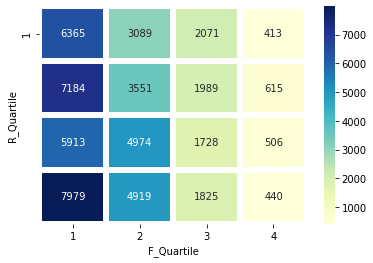

In [32]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

<h4>Проведем сегментацию клиентов

In [33]:
rfm_df = rfmSegmentation
rfm_df['RFM_Score'] = 0.15*rfm_df['R_Quartile']+0.28 * rfm_df['F_Quartile']+0.57*rfm_df['M_Quartile']
rfm_df = rfm_df.round(2)
rfm_df.sort_values('RFM_Score', ascending=False).head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFM_Score
Customer_name,,,,,,,,
Carl Ludwig,687,1,33.48,4,4,4,444,4.0
Shirley Daniels,1178,1,328.09,4,4,4,444,4.0
Shui Tom,1098,2,105.23,4,4,4,444,4.0
Liz Willingham,1148,1,383.85,4,4,4,444,4.0
John Dryer,1061,1,215.94,4,4,4,444,4.0


In [34]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >= 4, "Top Customers",
                            (np.where(rfm_df['RFM_Score'] >= 3.5,"High value Customer",
                            (np.where(rfm_df['RFM_Score'] >= 2.5,"Medium Value Customer",
                            np.where(rfm_df['RFM_Score'] >= 1.6,'Low Value Customers', 'Lost Customers'))))))
rfm_df.sort_values('RFM_Score', ascending=False).head()

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFM_Score,Customer_segment
Customer_name,,,,,,,,,
Carl Ludwig,687,1,33.48,4,4,4,444,4.0,Top Customers
Shirley Daniels,1178,1,328.09,4,4,4,444,4.0,Top Customers
Shui Tom,1098,2,105.23,4,4,4,444,4.0,Top Customers
Liz Willingham,1148,1,383.85,4,4,4,444,4.0,Top Customers
John Dryer,1061,1,215.94,4,4,4,444,4.0,Top Customers


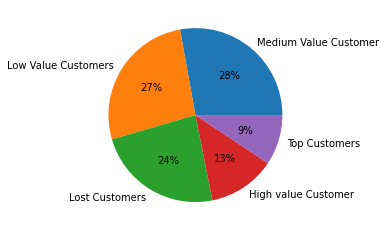

In [35]:
plt.pie(rfm_df.Customer_segment.value_counts(), labels=rfm_df.Customer_segment.value_counts().index, autopct='%.0f%%')
plt.show()


<h4>Анализ продукции

In [36]:
df.head()

,order_id,Order_date,Ship_date,Customer_name,Country,City,State,Category,Product_name,Sales,Quantity,Profit,grand_total
0,CA-2013-138688,2013-06-13,2013-06-17,Darrin Van Huff,United States,Los Angeles,California,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2.0,6.87,29.24
1,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7.0,14.17,342.02
2,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Art,Newell 322,7.28,4.0,1.97,29.12
3,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Phones,Mitel 5320 IP Phone VoIP phone,907.15,4.0,90.72,3628.60
4,CA-2011-115812,2011-09-06,2011-06-14,Brosina Hoffman,United States,Los Angeles,California,Binders,DXL Angle-View Binders with Locking Rings by S...,18.50,3.0,5.78,55.50


In [37]:
category_q = df.groupby(['Category'], as_index=False).agg({'Quantity':'sum'}).sort_values(['Quantity'], ascending = False).head(10)

In [38]:
category_p = df.groupby(['Category'], as_index=False).agg({'Profit':'sum'}).sort_values(['Profit'], ascending = False).head(10)

[None, Text(0.5, 1.0, 'ТОП - 10 прибыльных товаров')]

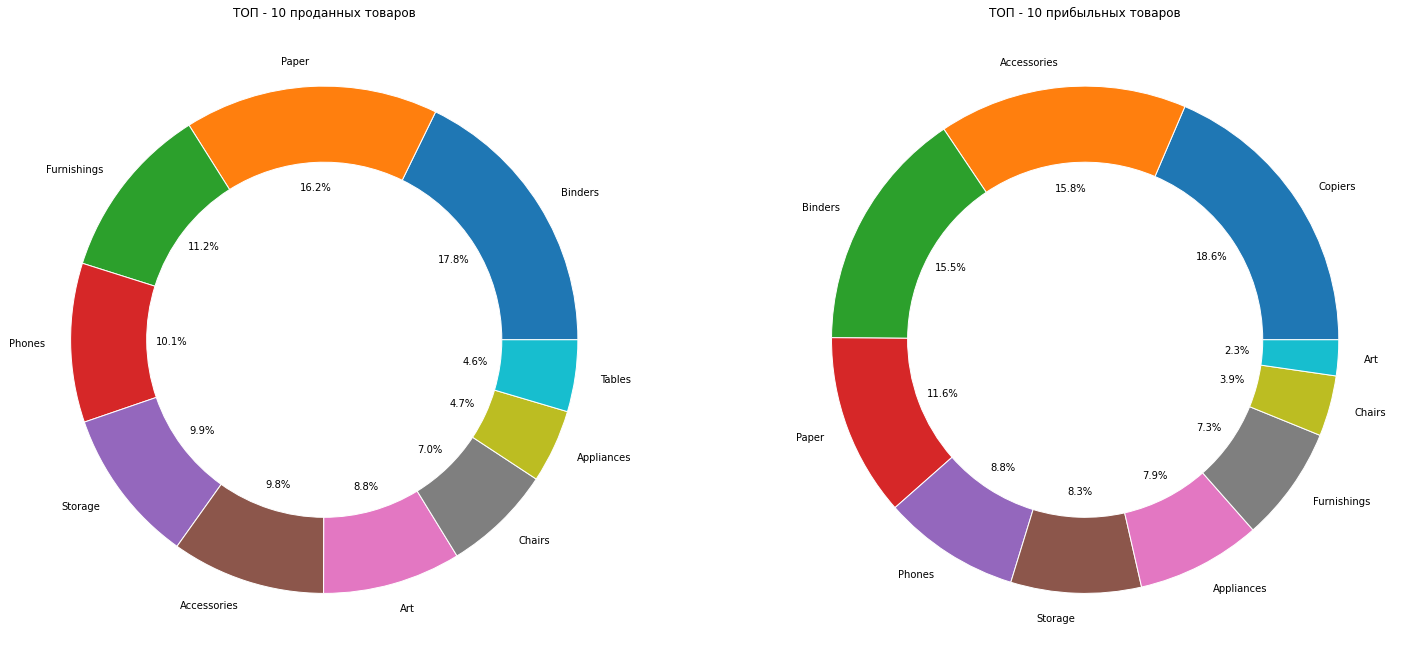

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))

size = 0.3
ax1.pie(category_q.Quantity.values.flatten(), radius=1,
       labels=category_q.Category.to_list(),
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
ax1.set(aspect="equal", title='ТОП - 10 проданных товаров')

ax2.pie(category_p.Profit.values.flatten(), radius=1,
       labels=category_p.Category.to_list(),
       autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))
ax2.set(aspect="equal", title='ТОП - 10 прибыльных товаров')


<h4>Аналитика по географии продаж

In [40]:
country = df.groupby(['Country', 'State', 'City'], as_index=False).agg({'grand_total':'sum'}).sort_values(['grand_total'], ascending = False)

In [41]:
country.head(10)

,Country,State,City,grand_total
46,United States,California,Los Angeles,871395.02
166,United States,Washington,Seattle,597615.19
73,United States,California,San Francisco,541425.66
72,United States,California,San Diego,260573.28
33,United States,California,Fresno,63330.67
7,United States,Arizona,Phoenix,52053.72
99,United States,Colorado,Denver,47899.35
13,United States,California,Anaheim,41361.69
17,United States,California,Brentwood,35974.15
11,United States,Arizona,Tucson,35688.24


In [42]:
country.tail(10)

,Country,State,City,grand_total
14,United States,California,Antioch,58.32
50,United States,California,Montebello,55.76
1,United States,Arizona,Bullhead City,36.66
106,United States,Colorado,Loveland,36.16
143,United States,Utah,Layton,19.84
116,United States,Montana,Billings,16.58
112,United States,Idaho,Lewiston,9.58
76,United States,California,San Luis Obispo,7.24
152,United States,Washington,Auburn,4.18
158,United States,Washington,Everett,3.86
